In [3]:
!pip install transformers

In [30]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7s2frk5e
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7s2frk5e
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 886.9 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.

In [4]:
import torch
from diffusers import AutoencoderKL
import os, math, numpy as np, pandas as pd, tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from matplotlib import pyplot as plt
from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16")  


os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)

strategy = tf.distribute.MirroredStrategy()  # uses all visible GPUs
print("GPUs:", len(gpus), "| replicas:", strategy.num_replicas_in_sync)

GPUs: 1 | replicas: 1


I0000 00:00:1755972262.857719      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema")

torch_device = "cuda" if torch.cuda.is_available() else "cpu"
vae.to(torch_device)
vae.eval()
print("VAE device:", torch_device)

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

VAE device: cuda


In [6]:
!wget -q https://huggingface.co/apapiu/latent_diffusion_keras/resolve/main/embeddings.npy -O embeddings.npy
!wget -q https://huggingface.co/apapiu/latent_diffusion_keras/resolve/main/16_16_latent_embeddings.npy -O 16_16_latent_embeddings.npy

train_label_embeddings2 =  np.load("embeddings.npy")
latent_train_data2 = np.load("16_16_latent_embeddings.npy")

# Replace these two lines with your own dataset paths if not on Kaggle:
train_label_embeddings =  np.load("/kaggle/input/text-to-image-dataset/text_embeddings.npy")
latent_train_data = np.load("/kaggle/input/text-to-image-dataset/image_latents.npy")

latent_train_data = np.concatenate((latent_train_data, latent_train_data2), axis=0)
train_label_embeddings = np.concatenate((train_label_embeddings, train_label_embeddings2), axis=0)

print("training dataset ready")
print("latent_train_data shape:", latent_train_data.shape)

training dataset ready
latent_train_data shape: (233668, 16, 16, 4)


In [44]:
def imshow(img):
    def norm_0_1(img):
        return (img + 1) / 2  # from [-1,1] to [0,1]
    if img.shape[-1] == 1:
        img = img.reshape(img.shape[0], img.shape[1])
    img = np.clip(img, -1, 1)
    plt.imshow(norm_0_1(img))

def plot_images(imgs, size=8, nrows=8, save_name=None):
    plt.rcParams["figure.figsize"] = (size, size)
    for i in range(len(imgs)):
        ax = plt.subplot(nrows, nrows, i + 1)
        imshow(imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if save_name:
        plt.savefig(f"{save_name}.png", dpi=200)
    plt.show()

In [40]:
def decode_latents(latent_arr, std_latent=1.0, batch_size=32):
    """
    latent_arr: numpy array, shape (N, H, W, 4), values typically in [-1,1]
    returns: numpy array of decoded images in [-1,1], shape (N, H*8, W*8, 3) depending on VAE config
    """
    decoded_imgs = []
    N = latent_arr.shape[0]
    with torch.no_grad():
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            # NHWC -> NCHW, float32 tensor on the VAE device
            encoded = torch.from_numpy(latent_arr[start:end] * float(std_latent)).permute(0, 3, 1, 2).to(torch_device, dtype=torch.float32)
            # Decode with the PyTorch VAE
            decoded = vae.decode(encoded).sample  # (N, 3, H_dec, W_dec), in [-1, 1]
            # NCHW -> NHWC, move to CPU numpy
            decoded_imgs.append(decoded.permute(0, 2, 3, 1).cpu().numpy())

    return np.concatenate(decoded_imgs, axis=0)



In [9]:
image_size = 16
num_channels = 4
epochs = 80
class_guidance = 4

block_depth = 3
emb_size = 512
embedding_dims = 32

batch_size = 256
num_imgs = 36

validation_num = 300
train_size = 100000
learning_rate = 3e-4

MODEL_NAME = "text_to_image"
home_dir = MODEL_NAME
os.makedirs(home_dir, exist_ok=True)
model_path = os.path.join(home_dir, MODEL_NAME + ".h5")

In [10]:
def attention(qkv):
    q, k, v = qkv
    vector = tf.matmul(k, q, transpose_b=True)
    score = tf.nn.softmax(vector)
    o = tf.matmul(score, v)
    return o

def spatial_attention(img):
    filters = img.shape[3]
    orig_shape = (img.shape[1], img.shape[2], img.shape[3])
    img = layers.BatchNormalization()(img)

    q = layers.Conv2D(filters // 8, 1, padding="same")(img)
    k = layers.Conv2D(filters // 8, 1, padding="same")(img)
    v = layers.Conv2D(filters, 1, padding="same")(img)

    k = layers.Reshape((k.shape[1] * k.shape[2], k.shape[3]))(k)
    q = layers.Reshape((q.shape[1] * q.shape[2], q.shape[3]))(q)
    v = layers.Reshape((v.shape[1] * v.shape[2], v.shape[3]))(v)

    img = layers.Lambda(attention)([q, k, v])
    img = layers.Reshape(orig_shape)(img)

    img = layers.Conv2D(filters, 1, padding="same")(img)
    img = layers.BatchNormalization()(img)
    return img

In [11]:
def cross_attention(img, text):
    filters = img.shape[3]
    orig_shape = (img.shape[1], img.shape[2], img.shape[3])
    img = layers.BatchNormalization()(img)
    text = layers.BatchNormalization()(text)

    q = layers.Conv2D(filters // 8, 1, padding="same")(text)
    k = layers.Conv2D(filters // 8, 1, padding="same")(img)
    v = layers.Conv2D(filters, 1, padding="same")(text)

    q = layers.Reshape((q.shape[1] * q.shape[2], q.shape[3]))(q)
    k = layers.Reshape((k.shape[1] * k.shape[2], k.shape[3]))(k)
    v = layers.Reshape((v.shape[1] * v.shape[2], v.shape[3]))(v)

    img = layers.Lambda(attention)([q, k, v])
    img = layers.Reshape(orig_shape)(img)

    img = layers.Conv2D(filters, 1, padding="same")(img)
    img = layers.BatchNormalization()(img)
    return img

In [12]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    embedding_max_frequency = 1000.0
    embedding_dims = 32
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

In [13]:
def ResidualBlock(channel_num):
    def apply(x):
        input_channel = x.shape[3]
        residual = x if input_channel == channel_num else layers.Conv2D(channel_num, 1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(channel_num, 3, padding="same", activation=keras.activations.swish)(x)
        x = layers.Conv2D(channel_num, 3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x
    return apply

In [14]:
def DownBlock(channel_num, block_depth, use_self_attention=True):
    def apply(x):
        x, skip, emb_and_noise = x
        for _ in range(block_depth):
            x = ResidualBlock(channel_num)(x)
            if use_self_attention:
                att = spatial_attention(x)
                x = layers.Add()([x, att])
                cross_att = cross_attention(x, emb_and_noise)
                x = layers.Add()([x, cross_att])
            skip.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x
    return apply

In [15]:
def UpBlock(channel_num, block_depth, use_self_attention=True):
    def apply(x):
        x, skips, emb_and_noise = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(channel_num)(x)
            if use_self_attention:
                att = spatial_attention(x)
                x = layers.Add()([x, att])
                cross_att = cross_attention(x, emb_and_noise)
                x = layers.Add()([x, cross_att])
        return x
    return apply

In [16]:
def get_network(latent_image_size, block_depth=3, emb_size=512, latent_channels=4):
    noisy_images = keras.Input(shape=(latent_image_size, latent_image_size, latent_channels))
    x = layers.Conv2D(128, 1)(noisy_images)

    noise_variances = keras.Input(shape=(1, 1, 1))
    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32),name="time_embedding")(noise_variances)
    e = layers.UpSampling2D(size=(latent_image_size, latent_image_size), interpolation="nearest")(e)

    input_label = layers.Input(shape=(emb_size,))
    emb_label = layers.Dense(emb_size // 2)(input_label)
    emb_label = layers.Reshape((1, 1, emb_size // 2))(emb_label)
    emb_label = layers.UpSampling2D(size=(latent_image_size, latent_image_size), interpolation="nearest")(emb_label)

    emb_and_noise = layers.Concatenate()([e, emb_label])
    skips_connections = []

    x = DownBlock(128, block_depth, use_self_attention=False)([x, skips_connections, emb_and_noise])
    emb_and_noise = layers.AveragePooling2D(pool_size=(2, 2))(emb_and_noise)

    x = DownBlock(256, block_depth)([x, skips_connections, emb_and_noise])
    emb_and_noise = layers.AveragePooling2D(pool_size=(2, 2))(emb_and_noise)

    x = DownBlock(512, block_depth)([x, skips_connections, emb_and_noise])
    emb_and_noise = layers.AveragePooling2D(pool_size=(2, 2))(emb_and_noise)

    for _ in range(block_depth):
        x = ResidualBlock(128*5)(x)
        o = spatial_attention(x)
        x = layers.Add()([x, o])
        cross_att = cross_attention(x, emb_and_noise)
        x = layers.Add()([x, cross_att])

    x = UpBlock(512, block_depth)([x, skips_connections, emb_and_noise])
    emb_and_noise = layers.UpSampling2D(size=(2, 2), interpolation="nearest")(emb_and_noise)

    x = UpBlock(256, block_depth)([x, skips_connections, emb_and_noise])
    emb_and_noise = layers.UpSampling2D(size=(2, 2), interpolation="nearest")(emb_and_noise)

    x = UpBlock(128, block_depth)([x, skips_connections, emb_and_noise])
    emb_and_noise = layers.UpSampling2D(size=(2, 2), interpolation="nearest")(emb_and_noise)

    x = layers.Conv2D(latent_channels, 1, kernel_initializer="zeros")(x)
    return keras.Model([noisy_images, noise_variances, input_label], x, name="unet")


In [17]:
np.random.seed(100)
num_imgs = 25
rand_image = np.random.normal(0, 1, (num_imgs, image_size, image_size, num_channels))

# with strategy.scope():
#     unet = get_network(16)
#     unet.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss="mae",
#         steps_per_execution=50,   # try 50 or 100
#     )

unet = get_network(16)
unet.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
print("Number of parameters:", unet.count_params())

Number of parameters: 83907332


In [18]:
ns = np.arange(10020,10020+5)
labels = []
for n in ns:
    for i in range(5):
        labels.append(train_label_embeddings[n])
labels = np.array(labels)

In [19]:
std_latent = np.std(latent_train_data)*2.5
latent_train_data = np.clip(latent_train_data, -std_latent, std_latent)
latent_train_data = latent_train_data/std_latent
print("std_latent", std_latent)

std_latent 10.423554182052612


In [20]:
def add_noise(array, mu=0, std=1):
    x = np.abs(np.random.normal(0, std, 2 * len(array)))
    x = x[x < 3]
    x = x / 3
    x = x[:len(array)]
    noise_levels = x
    noise_levels = np.sin(noise_levels)
    signal_levels = np.sqrt(1-np.square(noise_levels))
    noise_level_reshape = noise_levels[:, None, None, None]
    signal_level_reshape = signal_levels[:, None, None, None]
    pure_noise = np.random.normal(0, 1, size=array.shape).astype("float32")
    noisy_data = array * signal_level_reshape + pure_noise * noise_level_reshape
    return noisy_data, noise_levels


In [21]:
def dynamic_thresholding(img, perc=99.5):
    s = np.percentile(np.abs(img.ravel()), perc)
    s = np.max([s, 1])
    img = img.clip(-s, s) / s
    return img

class Diffuser:
    def __init__(self, denoiser, class_guidance, diffusion_steps, perc_thresholding=99.5, batch_size=64):
        self.denoiser = denoiser
        self.class_guidance = class_guidance
        self.diffusion_steps = diffusion_steps
        self.noise_levels = 1 - np.power(np.arange(0.0001, 0.99, 1 / self.diffusion_steps), 1 / 3)
        self.noise_levels[-1] = 0.01
        self.perc_thresholding = perc_thresholding
        self.batch_size = batch_size

    def predict_x_zero(self, x_t, label, noise_level):
        num_imgs = len(x_t)
        label_empty_ohe = np.zeros(shape=label.shape)
        noise_in = np.array([noise_level] * num_imgs)[:, None, None, None]
        nn_inputs = [np.vstack([x_t, x_t]),
                     np.vstack([noise_in, noise_in]),
                     np.vstack([label, label_empty_ohe])]
        x0_pred = self.denoiser.predict(nn_inputs, batch_size=self.batch_size, verbose=0)
        x0_pred_label = x0_pred[:num_imgs]
        x0_pred_no_label = x0_pred[num_imgs:]
        x0_pred = self.class_guidance * x0_pred_label + (1 - self.class_guidance) * x0_pred_no_label
        x0_pred = dynamic_thresholding(x0_pred, perc=self.perc_thresholding)
        return x0_pred

    def reverse_diffusion(self, seeds, label, show_img=False):
        new_img = seeds
        for i in range(len(self.noise_levels) - 1):
            curr_noise, next_noise = self.noise_levels[i], self.noise_levels[i + 1]
            x0_pred = self.predict_x_zero(new_img, label, curr_noise)
            new_img = ((curr_noise - next_noise) * x0_pred + next_noise * new_img) / curr_noise
            if show_img:
                plot_images(x0_pred, nrows=int(np.sqrt(len(new_img))), save_name=str(i), size=12)
                plt.show()
        return x0_pred


In [22]:
def batch_generator(model, model_path, train_data, train_label_embeddings, epochs,
                    batch_size, rand_image, labels, home_dir, diffuser, epoch=0):
    indices = np.arange(len(train_data))
    batch = []
    print("Training for {0}".format(epochs))
    while epoch < epochs:
        print("saving model:")
        model.save(model_path)  # TF SavedModel

        if epoch % 1 == 0:
            diffuser.denoiser = model
            imgs = diffuser.reverse_diffusion(rand_image, labels)
            imgs = decode_latents(imgs, std_latent=std_latent)
            img_path = os.path.join(home_dir, str(epoch))
            plot_images(imgs, save_name=img_path, nrows=int(np.sqrt(len(imgs))))

        print("new epoch {0}".format(epoch))
        np.random.shuffle(indices)
        for i in indices:
            batch.append(i)
            if len(batch) == batch_size:
                tr_batch = train_data[batch].copy()

                s = np.random.binomial(1, 0.15, size=batch_size).astype("bool")
                train_label_dropout = train_label_embeddings[batch].copy()
                train_label_dropout[s] = np.zeros(shape=train_label_embeddings.shape[1])

                noisy_train_data, noise_level_train = add_noise(tr_batch, mu=0, std=1)
                noise_level_train = noise_level_train[:, None, None, None]

                yield (noisy_train_data, noise_level_train, train_label_dropout), tr_batch
                batch = []
        epoch += 1


In [23]:
batch_size = 256
diffuser = Diffuser(unet, class_guidance=class_guidance, diffusion_steps=100, perc_thresholding=99.75)

train_generator = batch_generator(unet,
                                  model_path,
                                  latent_train_data,
                                  train_label_embeddings,
                                  epochs,
                                  batch_size,
                                  rand_image,
                                  labels,
                                  home_dir,
                                  diffuser)

Training for 80
saving model:


I0000 00:00:1755972291.844080     107 service.cc:148] XLA service 0x7fb8640b05c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755972291.844871     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755972293.102169     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755972299.717712     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


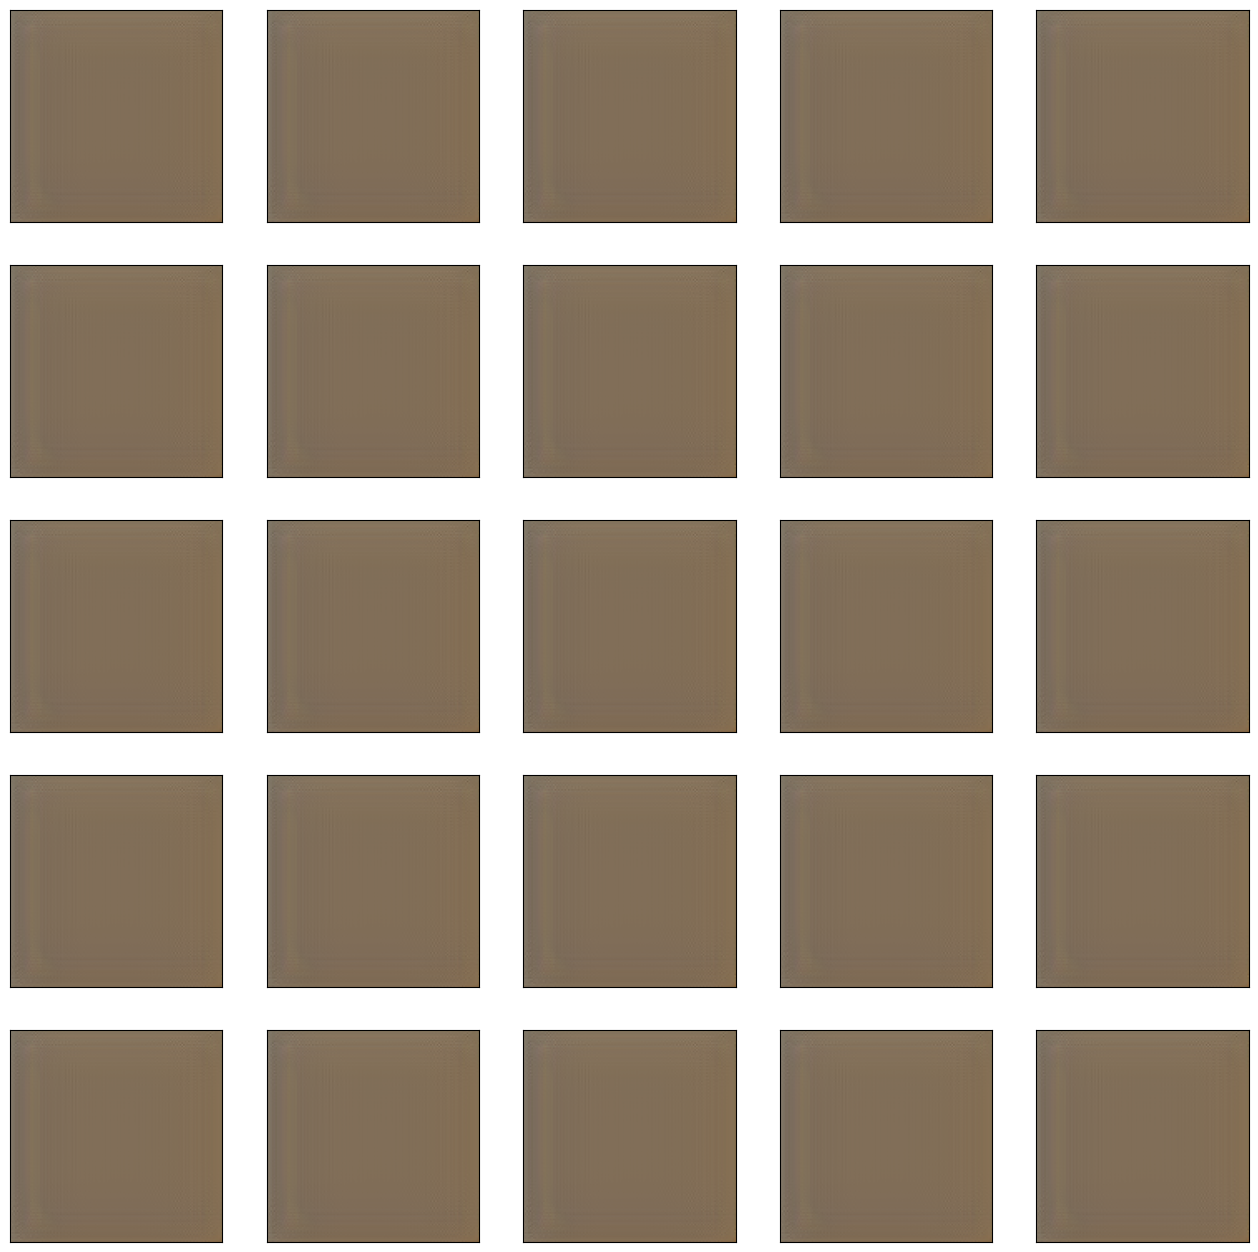

new epoch 0
Epoch 1/80
    911/Unknown 627s 467ms/step - loss: 0.1555saving model:
    912/Unknown 627s 467ms/step - loss: 0.1555

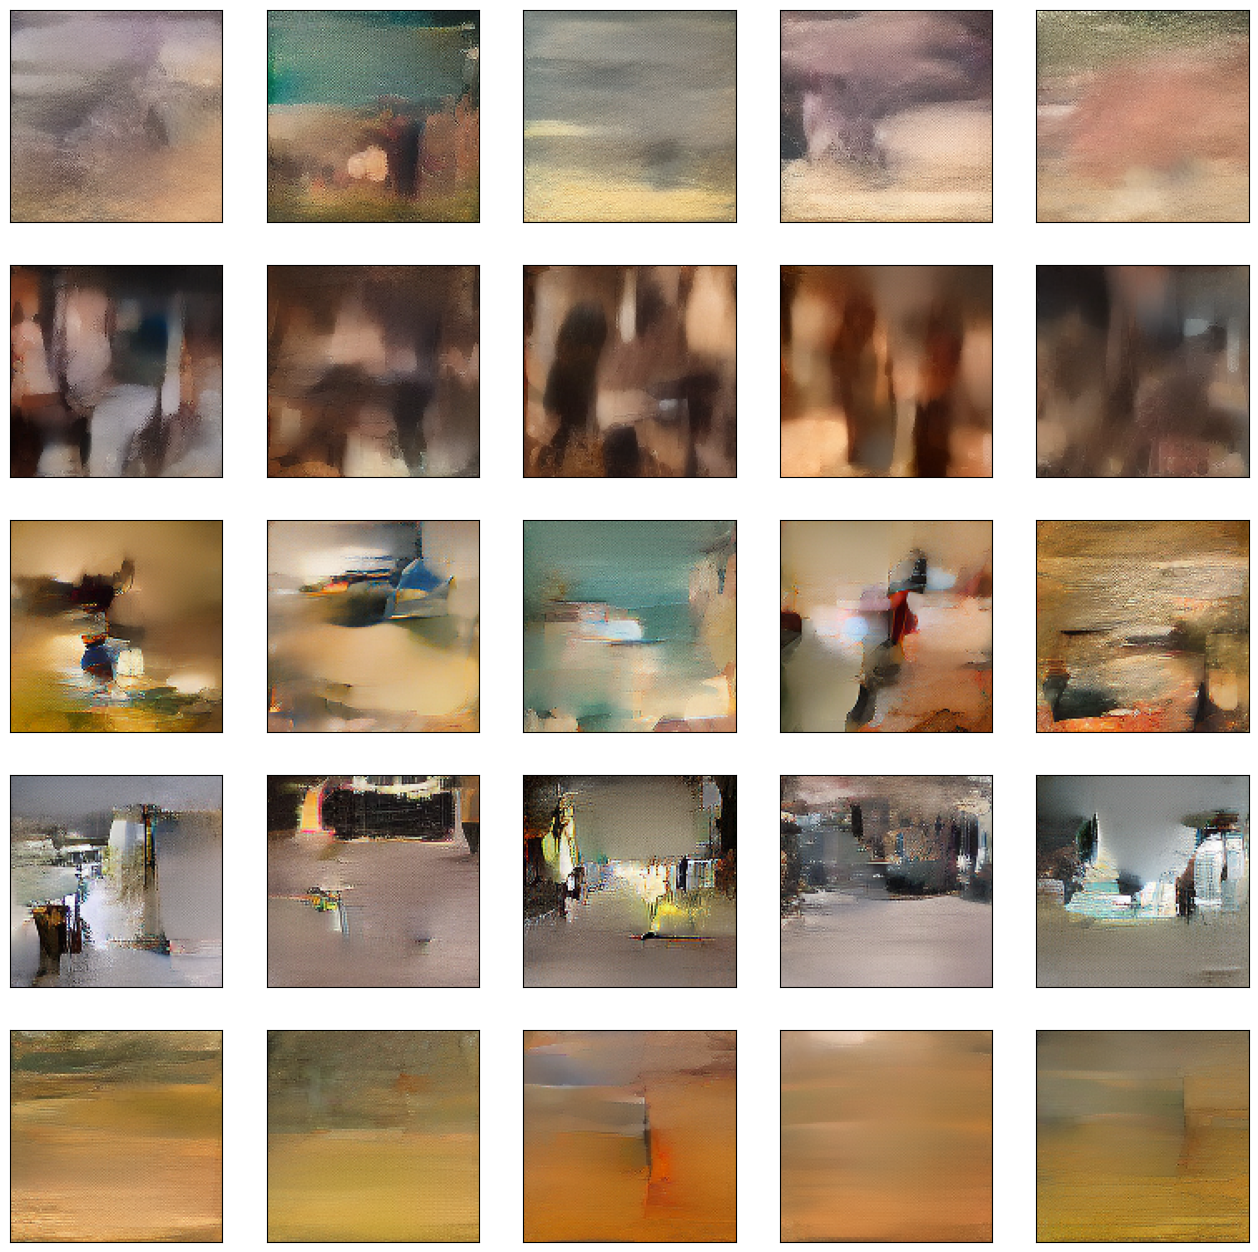

new epoch 1
   1019/Unknown 698s 488ms/step - loss: 0.1538

KeyboardInterrupt: 

In [24]:
history = unet.fit(x=train_generator, epochs=epochs)

In [53]:
unet = keras.models.load_model(
        "/kaggle/working/text_to_image/text_to_image.h5",
        custom_objects={"sinusoidal_embedding": sinusoidal_embedding, "attention": attention},
        compile=False,
    )

In [54]:
diffuser = Diffuser(unet,
                    class_guidance=6,
                    diffusion_steps=100, perc_thresholding=99.75)

In [55]:
import torch
import clip
# Load the CLIP model and tokenizer  cuda
model, tokenizer = clip.load("ViT-B/32")

In [63]:
text = "beautiful landscape with river"
text_tokens = clip.tokenize(text, truncate=False).cuda()

with torch.no_grad():
    text_encoding = model.encode_text(text_tokens)

text_encoding = np.vstack(text_encoding.repeat(4, 1).cpu())

In [64]:
text_encoding.shape

(4, 512)

In [65]:
rand_image = np.random.normal(0, 1, (4, 16, 16, 4))

In [66]:
from tqdm import tqdm
import matplotlib.pyplot as plt
diffuser.denoiser = unet

with torch.no_grad():
    imgs = diffuser.reverse_diffusion(rand_image, text_encoding)
    imgs = decode_latents(imgs, std_latent=10.709713697433472)

In [67]:
imgs.shape

(4, 128, 128, 3)

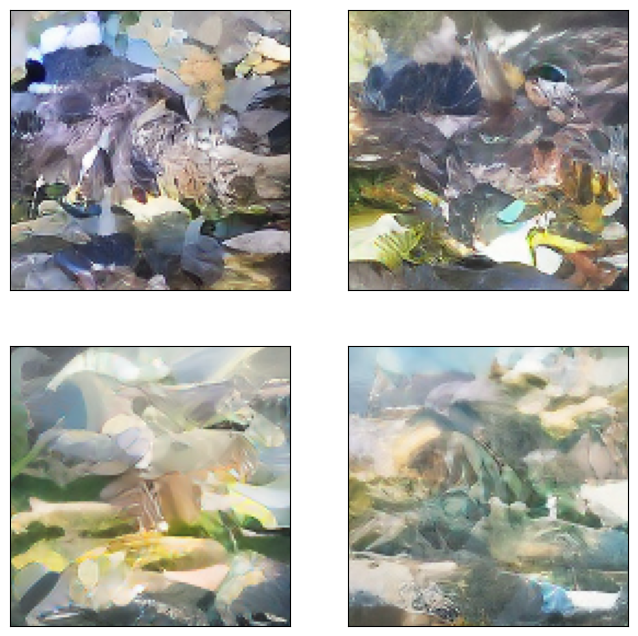

In [69]:
plot_images(imgs, nrows=2, save_name = text)